In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import scanpy as sc
from matplotlib import cm, colors
from scipy import stats, spatial, sparse
from glob import glob
import networkx as nx
np.random.seed(42)

## Import Data

In [2]:
dataset_ID = 'E2' #C1, D1, E2
dataset_path = '../data/CN21_' + dataset_ID + '_cell_types.tsv'
df = pd.read_csv(dataset_path)
#df.head()

In [3]:
cell_type_names = df['cell_type'].unique()
n_cell_types = len(cell_type_names)
cell_type_name_id_dict = dict(zip(cell_type_names, np.arange(0, n_cell_types).astype(int)))
reg_names = df['poly.ID'].unique()
n_regions = len(reg_names)
reg_name_id_dict = dict(zip(reg_names, np.arange(0, n_regions)))
print("%s cell types" % n_cell_types)
print("%s regions" % n_regions)

6 cell types
14 regions


### Assign colors for visualization

In [4]:
cmap = cm.get_cmap('nipy_spectral', n_cell_types)

color_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    #print(colors.rgb2hex(rgb))
    color_list.append(colors.rgb2hex(rgb))

type_color_dict = dict(zip(cell_type_names, color_list))


cmap = cm.get_cmap('nipy_spectral', n_regions)

color_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    #print(colors.rgb2hex(rgb))
    color_list.append(colors.rgb2hex(rgb))

reg_color_dict = dict(zip(reg_names, color_list))

### Add IDs and colors to DataFrame

In [5]:
df['cell_type_id'] = df['cell_type'].apply(lambda x: cell_type_name_id_dict[x])
df['region_id'] = df['poly.ID'].apply(lambda x: reg_name_id_dict[x])
df['cell_type_color'] = df['cell_type'].apply(lambda x: type_color_dict[x])
df['reg_color'] = df['poly.ID'].apply(lambda x: reg_color_dict[x])

In [6]:
df.head()

,bc,segment_id,segment_px_x,segment_px_y,cell_type,poly.ID,cell_type_id,region_id,cell_type_color,reg_color
1,1000x17,7622,9286.251723,1112.430409,epithelial,Fatty tissue,0,0,#000000,#000000
2,1000x175,16386,9287.929553,2254.195876,endothelial,Fatty tissue;Fibrous tissue;Invasive cancer;im...,1,1,#0000dd,#800091
3,1000x254,21270,9262.589988,2831.436234,epithelial,Fibrous tissue;Invasive cancer;immune/lymphoid,0,2,#000000,#0000ae
4,1000x287,23836,9273.606853,3098.420198,stroma,Fibrous tissue;Invasive cancer;immune/lymphoid,2,2,#00aa88,#0000ae
5,1000x313,25182,9278.407143,3253.669481,epithelial,Invasive cancer,0,3,#000000,#0049dd


## Visualize

<Figure size 432x288 with 0 Axes>

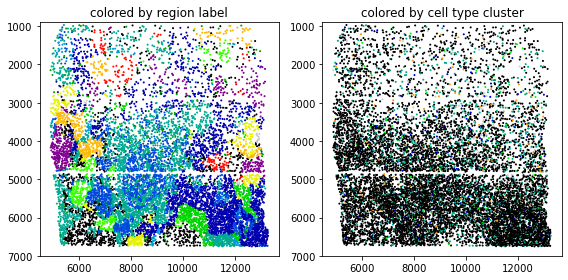

In [7]:
plt.clf()
fix, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
ax1.scatter(df['segment_px_x'], df['segment_px_y'], color=df['reg_color'], marker='o', s=1)
ax1.set_title('colored by region label')
ax1.set_ylim(7000,900)
ax2.scatter(df['segment_px_x'], df['segment_px_y'], color=df['cell_type_color'], marker='o', s=1)
ax2.set_title('colored by cell type cluster')
ax2.set_ylim(7000,900)
#plt.gca().invert_yaxis()
plt.savefig('../fig/full_data_region_type_sidebyside.pdf')
plt.tight_layout()
plt.show()

### make regions data

In [8]:
def calculate_tiles(min_x, max_x, min_y, max_y, tile_size):
    L = max_x - min_x
    W = max_y - min_y
    l = np.ceil(L/tile_size)
    w = np.ceil(W/tile_size)
    print(l, w)
    print(l*w)
    return int(l), int(w)

In [9]:
tile_size = 750

min_x = int(np.floor(min(df['segment_px_x'])))
max_x = int(np.ceil(max(df['segment_px_x'])))

min_y = int(np.floor(min(df['segment_px_y'])))
max_y = int(np.ceil(max(df['segment_px_y'])))

l, w = calculate_tiles(min_x, max_x, min_y, max_y, tile_size)
x_bounds = [i for i in range(min_x, max_x+tile_size-1, tile_size)]
y_bounds = [i for i in range(min_y, max_y+tile_size-1, tile_size)]

tile_types_needed=[]

for i in range(1, len(x_bounds)):
    for j in range(1, len(y_bounds)):
        min_x = int(np.round(x_bounds[i - 1]))
        max_x = int(np.round(x_bounds[i]))
        min_y = int(np.round(y_bounds[j - 1]))
        max_y = int(np.round(y_bounds[j]))

        #Subset the dataframe 
        temp = df[(df['segment_px_x'] >= min_x) & (df['segment_px_x'] < max_x) & 
                  (df['segment_px_y'] >= min_y) & (df['segment_px_y'] < max_y)]
        
        if len(temp)> 3:
            values, counts = np.unique(np.array(temp['poly.ID']), return_counts=True)
            tile_type = values[np.argmax(counts)]
        else:
            tile_type= 'null'
        tile_types_needed.append(tile_type)

tile_values, tile_counts = np.unique(tile_types_needed, return_counts=True)

12.0 8.0
96.0


<Figure size 432x288 with 0 Axes>

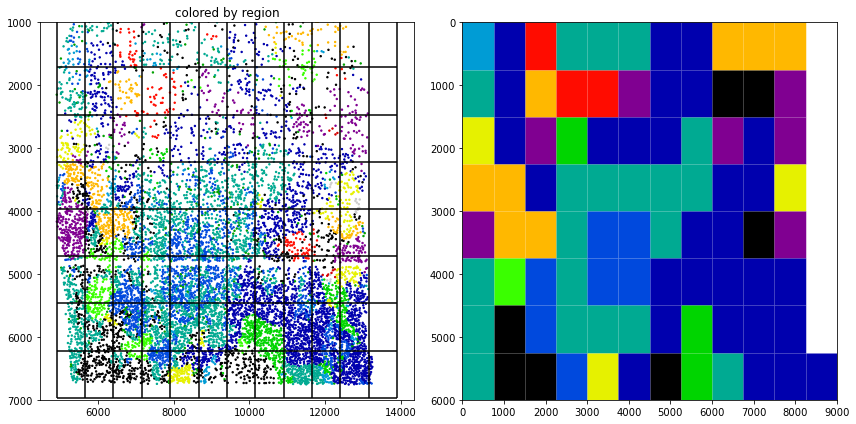

In [10]:
import matplotlib

plt.clf()
fix, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
ax1.scatter(df['segment_px_x'], df['segment_px_y'], color=df['reg_color'], marker='o', s=2)
ax1.hlines(y_bounds,min(x_bounds), max(x_bounds))
ax1.vlines(x_bounds,min(y_bounds), max(y_bounds))
ax1.set_ylim(7000,1000)
ax1.set_title('colored by region')

patches=[]
for i in range(0, len(tile_types_needed)):
    tile_type = tile_types_needed[i]
    if tile_type != 'null':
        color = reg_color_dict[tile_type]
    else:
        color = '#FFFFFF'
    
    j = int(np.floor(i/w))
    k = int(i % w)
    
    #y_hi = y_bounds[k+1] - y_bounds[0]
    y_low = y_bounds[k] - y_bounds[0]
    x_low = x_bounds[j] - x_bounds[0]
    
    r = plt.Rectangle((x_low,y_low), x_bounds[1]- x_bounds[0], y_bounds[1]- y_bounds[0], facecolor=color)
    
    patches.append(r)

p = matplotlib.collections.PatchCollection(patches, match_original=True)
ax2.add_collection(p)
ax2.set_ylim(6000,0)
ax2.set_xlim(0,9000)
    
#plt.savefig('../fig/' + dataset_name + '_full_data_by_region.pdf')
plt.tight_layout()
plt.show()

In [11]:
cells_per_tile = np.round(len(df)/(l*w))
print(cells_per_tile)

103.0


## Reconstruct network of cells

In [12]:
points = np.array([(df['segment_px_x'][i], df['segment_px_y'][i]) for i in df.index])
point_tree = spatial.cKDTree(points) #efficient search structure

In [13]:
def find_neighbors(start_point, search_radius, point_tree):
    '''
    Returns
    -------
    list of indicies in points that are within search_radius of start_point.
    '''
    return point_tree.query_ball_point(start_point, search_radius)

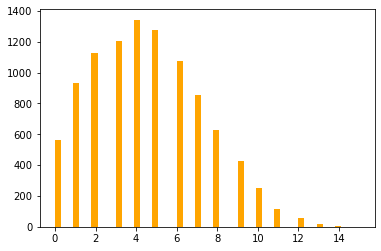

In [14]:
search_radius = 70 #1 pixel = μm
neighbors = [find_neighbors(points[i], search_radius, point_tree) for i in range(0, len(points))] 

#Visualize
neighbor_count_dist = [len(neighbors[i]) - 1 for i in range(0, len(neighbors))]
plt.hist(neighbor_count_dist, bins=50, color = 'orange')
plt.show()

In [15]:
zero_deg_indices = np.where(np.array(neighbor_count_dist) == 0)[0]

In [16]:
from sklearn.neighbors import NearestNeighbors

In [17]:
knn = NearestNeighbors(n_neighbors=7)
knn.fit(points)

for i in range(0, len(zero_deg_indices)):
    distance, kneighbors = knn.kneighbors(points[zero_deg_indices[i]].reshape(1,-1))
    k = np.random.randint(3,7)
    neighbors[zero_deg_indices[i]] = kneighbors[0][:k+1].tolist()

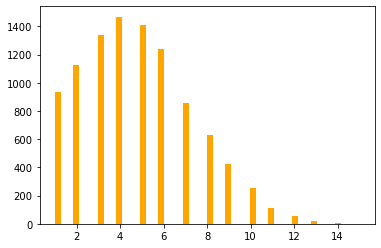

In [18]:
#Visualize
neighbor_count_dist = [len(neighbors[i]) - 1 for i in range(0, len(neighbors))]
plt.hist(neighbor_count_dist, bins=50, color = 'orange')
plt.show()

<Figure size 432x288 with 0 Axes>

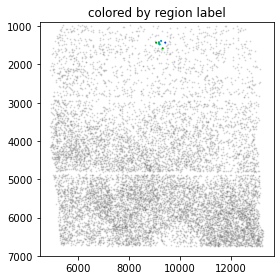

In [19]:
df_temp = df.iloc[kneighbors[0]]
plt.clf()
fix, ax1 = plt.subplots(1,1, figsize = (4,4))
ax1.scatter(df['segment_px_x'], df['segment_px_y'], color='k', alpha=0.1, marker='o', s=1)
ax1.scatter(df_temp['segment_px_x'], df_temp['segment_px_y'], color=df_temp['reg_color'], marker='o', s=1)
ax1.set_title('colored by region label')
ax1.set_ylim(7000,900)
#plt.gca().invert_yaxis()
#plt.savefig('../fig/full_data_region_type_sidebyside.pdf')
plt.tight_layout()
plt.show()

### Build graph

In [22]:
G = nx.Graph() #empty graph
node_ids = [i - 1 for i in df.index] #list of node_ids
G.add_nodes_from(node_ids)

#Connect the nodes
for i in range(0, len(node_ids)):
    for j in neighbors[i]:
        if j == i: 
            pass #no self loops
        else:
            G.add_edge(i, j)

In [23]:
sparse.save_npz('../data/hdst_bc_E2_adjmat_'+str(search_radius) + 'px.npz', nx.to_scipy_sparse_matrix(G))

## Calculate full image parameters

In [20]:
import sys
sys.path.insert(0, "../../") #this is wild you need to fix this if you show anyone else
from spatialpower.neighborhoods import permutationtest as perm_test

In [35]:
A_full = sparse.load_npz('../data/hdst_bc_E2_adjmat_'+str(search_radius) + 'px.npz')
G_full = nx.from_scipy_sparse_matrix(A_full)

In [36]:
def build_assignment_matrix(attribute_dict, n_cell_types):
    data = list(attribute_dict.items())
    data = np.array(data)  # Assignment matrix

    B = np.zeros((data.shape[0], n_cell_types))  # Empty matrix

    for i in range(0, data.shape[0]):
        t = int(data[i, 1])
        B[i, t] = 1

    return B

In [37]:
attribute_dict = dict(zip(df.index, df['cell_type_id']))
B_full = build_assignment_matrix(attribute_dict, n_cell_types)

In [38]:
p_full = np.divide(np.sum(B_full, axis=0), B_full.shape[0])
H_full = perm_test.calculate_neighborhood_distribution_sparse(A_full, B_full)

In [29]:
[i for i in G.neighbors(0)]

[9728, 9696, 9706, 246, 229, 9866]

In [30]:
np.unique(np.sum(A_full, axis = 1))

matrix([[ 1,  1,  1, ..., 14, 14, 15]])

In [31]:
B_full.shape[0] == len(df)

True

## Calculate region specfic parameters

In [32]:
def calculate_region_params(reg_name, graph, df, save=True, ret_vals=False):
   
    reg_code = 'reg_' + str(reg_name)
    region_df = df[df['region_id'] == reg_name]
    region_node_ids = [x-1 for x in region_df.index] #the pd dataframe is 1-indexed but the graph is 0-indexed
    region_subgraph = G.subgraph(region_node_ids)
    region_points = np.array([(region_df['segment_px_x'][i], region_df['segment_px_y'][i]) for i in region_df.index])
    region_subgraph = nx.Graph(region_subgraph) #unfreeze graph, weird nx behavior.
    knn = NearestNeighbors(n_neighbors=7)
    knn.fit(region_points)
    isolates = np.sort([i for i in nx.isolates(region_subgraph)])
    
    for i in range(0, len(isolates)):
        isolate = isolates[i] #this will be off by one on the index of region_df, so add 1 in next step.
        pt = np.array([region_df.loc[isolate + 1]['segment_px_x'], region_df.loc[isolate +1]['segment_px_y']]).reshape(1,-1)
        distance, kneighbors = knn.kneighbors(pt)
        k = np.random.randint(2,6)
        kneighbors = kneighbors[0][:k+1].tolist()
        for kn in kneighbors:
            #print(kn)
            node = region_df.index[kn] - 1 #correct the 1 offset. 
            assert node in region_subgraph.nodes()
            region_subgraph.add_edge(isolate, node)
    
    
    #region_df['ClusterID'] = region_df['cell_type'].apply(lambda x: cell_type_id_dict[x])
    attribute_dict = dict(zip(region_node_ids, region_df['cell_type_id']))
    
    A = nx.convert_matrix.to_scipy_sparse_matrix(region_subgraph)
    B = build_assignment_matrix(attribute_dict, n_cell_types)
    p = np.divide(np.sum(B, axis=0), A.shape[0])
    H = perm_test.calculate_neighborhood_distribution_sparse(A, B)
    
    if save:
        sparse.save_npz('../data/' + reg_code + '_A_'+ str(search_radius) + 'px.npz', A)
        np.save('../data/' + reg_code + '_B_'+ str(search_radius) + 'px.npy', B)
        np.save('../data/' + reg_code + '_p_'+ str(search_radius) + 'px.npy', p)
        np.save('../data/' + reg_code + '_H_'+ str(search_radius) + 'px.npy', H)
        print(H[5,5])
    if ret_vals:
        return A, B, p, H, region_subgraph, region_df
    else:
        return
    

In [36]:
reg_ids = df['region_id'].unique()
for reg_id in reg_ids:
    calculate_region_params(reg_id, G, df, save=False, ret_vals=True)

../../spatialpower/neighborhoods/permutationtest.py:177: RuntimeWarning: divide by zero encountered in true_divide
  aux2 = 1/cell_type_counts
../../spatialpower/neighborhoods/permutationtest.py:177: RuntimeWarning: divide by zero encountered in true_divide
  aux2 = 1/cell_type_counts
../../spatialpower/neighborhoods/permutationtest.py:177: RuntimeWarning: divide by zero encountered in true_divide
  aux2 = 1/cell_type_counts


## Generate Tiles

In [23]:
import operator
from spatialpower.tissue_generation import assign_labels, random_circle_packing

In [30]:
values, counts = np.unique(tile_types_needed, return_counts=True)
counts

array([ 7,  3,  7,  1,  8,  1, 20, 29,  3,  7,  3,  7])

In [31]:
def generate_tiles_heuristic(adjacency_matrix, C, graph, p, H, reg_code, outdir, n_tiles):
    
    #Set up positions
    position_dict = dict()
    for i in range(0, C.shape[0]):
        position_dict[i] = C[i, :]
       
    i=0
    while i <= n_tiles:
        attribute_dict = assign_labels.heuristic_assignment(graph, p, H, 'region', 300, position_dict, 60, revision_iters=5, n_swaps=1)
        heuristic_B = build_assignment_matrix(attribute_dict, n_cell_types)
        np.save(outdir + str(reg_code) + '_tile' + str(i) + '_' + str(C.shape[0]) + 'cells.npy', heuristic_B)
        '''if i % 50 == 0: 
            print(i)'''
        i += 1
    
    return
    

In [40]:
adjacency_matrix = np.load('../data/adj_mat_112_cell_tissue_scaffold_tile.npy')
C = np.load('../data/C_112_cell_tissue_scaffold_tile.npy')
tile_count_dict = dict(zip(values, counts))
outdir = '../data/tiles/'
graph = nx.from_numpy_matrix(adjacency_matrix)

In [41]:
for j in range(0, len(values) - 1):
    reg_name = values[j]
    n_tiles = tile_count_dict[reg_name]
    print(reg_name)
    print("Generating %s tiles..." % n_tiles)
    outdir = '../data/tiles/'

    reg_code = 'reg_' + str(reg_name_id_dict[reg_name])


    p = np.load('../data/' + reg_code + '_p_'+ str(search_radius) + 'px.npy')
    H = np.load('../data/' + reg_code + '_H_'+ str(search_radius) + 'px.npy')

    generate_tiles_heuristic(adjacency_matrix, C, graph, p, H, reg_code, outdir, n_tiles)

Fatty tissue
Generating 7 tiles...
0
Fatty tissue;Fibrous tissue;Invasive cancer
Generating 3 tiles...
0
Fatty tissue;Fibrous tissue;Invasive cancer;immune/lymphoid
Generating 7 tiles...
0
Fatty tissue;Invasive cancer
Generating 1 tiles...
0
Fatty tissue;Invasive cancer;immune/lymphoid
Generating 8 tiles...
0
Fibrous tissue
Generating 1 tiles...
0
Fibrous tissue;Invasive cancer
Generating 20 tiles...
0
Fibrous tissue;Invasive cancer;immune/lymphoid
Generating 29 tiles...
0
Fibrous tissue;immune/lymphoid
Generating 3 tiles...
0
Invasive cancer
Generating 7 tiles...
0
Invasive cancer;immune/lymphoid
Generating 3 tiles...
0


## Stitching

In [43]:
import math 
tile_size = 300 #this is the size of the GENERATED TILE!
n_cells_per_tile = C.shape[0]

y_bounds = np.linspace(0, tile_size*w, num=w + 1)
x_bounds = np.linspace(0, tile_size*l, num=l + 1)

shifts = []
C_composite = C.copy()
for i in range(0, len(tile_types_needed)):
    
    if i > 0:
        horiz_pos = math.floor((i)/w) #returns a 0 indexed position in the row (x adjustment in composite)
        vert_pos = i % w #returns a 0 indexed position in the column (e.g. y adjustment in composite)
        #tile_type = tile_ids[i]
        x_inc = x_bounds[1]
        y_inc = y_bounds[1]

        x_adjustment = horiz_pos * x_inc
        y_adjustment = vert_pos * y_inc

        shifts.append([x_adjustment, y_adjustment])

        C_shift = np.zeros(C.shape)
        C_shift[:, 0] = C[:, 0] + x_adjustment + np.random.rand()
        C_shift[:, 1] = C[:, 1] + y_adjustment + np.random.rand()
        
        C_composite = np.vstack((C_composite, C_shift))

#Remove the elements of C that are in blank tiles. 
a, = np.where(np.array(tile_types_needed) == 'null')

C_composite_trim = C_composite.copy()
to_delete = []
for tile_id in a:
    temp = [i + n_cells_per_tile*tile_id for i in range(0, n_cells_per_tile)]
    for t in temp:
        to_delete.append(t)
        
mask = [i for i in range(0, C_composite.shape[0]) if i not in to_delete]

C_composite_trim = C_composite[mask]
np.save('../data/tiles/C_composite_trim.npy', C_composite_trim)

### Composite B

In [44]:
B_lists = []
for i in range(0, len(values) - 1):
    reg_name = values[i] 
    reg_code = 'reg_' + str(reg_name_id_dict[reg_name])
    
    B_list = glob('../data/tiles/'+ reg_code + '_*.npy')
    B_lists.append(B_list) 

B_dict = dict(zip(values[:-1],B_lists))

In [45]:
indices = dict(zip(values, [0 for i in range(0, len(values))]))
for i in range(0, len(tile_types_needed)):
    if i%100 == 0:
        print(i)
    tile_type = tile_types_needed[i]
    
    if tile_type != 'null':
        files = B_dict[tile_type]
        arr = files[indices[tile_type]]
        indices[tile_type] += 1
    
        if i == 0:
            B_composite = np.load(arr)
        else:
            try:
                B_composite = np.vstack((B_composite, np.load(arr)))
            except NameError:
                B_composite = np.load(arr)
            if np.load(arr).shape[0] != n_cells_per_tile:
                print(arr)

np.save('../data/tiles/B_composite.npy', B_composite)

0


### Composite Graph

In [46]:
#adjacency_matrix = np.load('../data/adj_mat_50_cell_tissue_scaffold_tile.npy')
#C = np.load('../data/C_50_cell_tissue_scaffold_tile.npy')
#R = np.load('../../R_51_cell_tissue_scaffold_tile.npy')
graph = nx.from_numpy_matrix(adjacency_matrix)

In [47]:
max_x = max(C[:,0])
max_y = max(C[:,1])
buffer = 30 #how close to the border we want to consider
x_edge_donors, = np.where(C[:, 0] > (max_x - buffer)) #these are the nodes close to the right side that need to be connected to
x_edge_acceptors, = np.where(C[:, 0] < buffer) #these are the nodes close to the left side that need to be connected to

In [48]:
a = np.hstack((x_edge_acceptors.reshape((x_edge_acceptors.shape[0],1)), C[x_edge_acceptors, :]))
a[a[:,2].argsort()] #sort by y position
b = a[a[:,2].argsort()]
sorted_x_edge_acceptors = b[:,0]

a = np.hstack((x_edge_donors.reshape((x_edge_donors.shape[0],1)), C[x_edge_donors, :]))
a[a[:,2].argsort()] #sort by y position
b = a[a[:,2].argsort()]
sorted_x_edge_donors = b[:,0]

y_edge_donors, = np.where(C[:, 1] > (max_y - buffer)) #these are the nodes close to the bottom side that need to be connected to
y_edge_acceptors, = np.where(C[:, 1] < buffer) #these are the nodes close to the top side that need to be connected to

a = np.hstack((y_edge_acceptors.reshape((y_edge_acceptors.shape[0],1)), C[y_edge_acceptors, :]))
a[a[:,1].argsort()] #sort by y position
b = a[a[:,1].argsort()]
sorted_y_edge_acceptors = b[:,0]

a = np.hstack((y_edge_donors.reshape((y_edge_donors.shape[0],1)), C[y_edge_donors, :]))
a[a[:,1].argsort()] #sort by y position
b = a[a[:,1].argsort()]
sorted_y_edge_donors = b[:,0]

In [49]:
x_stitch_dict = dict()
y_stitch_dict = dict()

for i in range(0, sorted_x_edge_donors.shape[0]):
    if i < len(sorted_x_edge_acceptors):
        donor_id = int(sorted_x_edge_donors[i])
        acceptor_id = int(sorted_x_edge_acceptors[i])
    else:
        #the donors list longer than acceptors
        donor_id = int(sorted_x_edge_donors[i])
        acceptor_id = int(sorted_x_edge_acceptors[-1]) #just stick it to the last node
    
    x_stitch_dict[donor_id] = acceptor_id
    
for i in range(0, sorted_y_edge_donors.shape[0]):
    if i < len(sorted_y_edge_acceptors):
        donor_id = int(sorted_y_edge_donors[i])
        acceptor_id = int(sorted_y_edge_acceptors[i])
    else:
        #the donors list longer than acceptors
        donor_id = int(sorted_y_edge_donors[i])
        acceptor_id = int(sorted_y_edge_acceptors[-1]) #just stick it to the last node
    
    y_stitch_dict[donor_id] = acceptor_id

In [50]:
new_graph = graph.copy()
composite_graph = nx.disjoint_union(graph, new_graph)

for i in range(0, len(tile_types_needed) - 2):
    #this can be quite slow for large n_tiles, be sure to save your result.
    #TO DO: implement alternative approach for speed. 
    '''if i % 100 == 0:
        print(i)'''
    composite_graph = nx.disjoint_union(composite_graph, new_graph) 

0


In [51]:
n_cells_per_tile = C.shape[0]
current_tile_id = 0
l=int(l)
w=int(w)
for tile_x_index in range(0, l):
    for tile_y_index in range(0,w):
        if tile_x_index < l - 1:
            if tile_y_index < w-1: 
                for i in sorted_y_edge_donors:
                    y_acceptor = y_stitch_dict[i]
                    source = int(i) + (n_cells_per_tile * current_tile_id)
                    target = y_acceptor + (n_cells_per_tile * (current_tile_id + 1))
                    composite_graph.add_edge(source, target)

                for i in sorted_x_edge_donors:
                    x_acceptor = x_stitch_dict[i]
                    source = int(i) + (n_cells_per_tile * current_tile_id)
                    #target = x_acceptor + (239 * (current_tile_id + 20))
                    target = (x_acceptor + (n_cells_per_tile * current_tile_id)) + (n_cells_per_tile * w)
                    composite_graph.add_edge(source, target)
            else:
                # we're in the bottom row, so only stitch horizontally.
                for i in sorted_x_edge_donors:
                    x_acceptor = x_stitch_dict[i]
                    source = int(i) + (n_cells_per_tile * current_tile_id)
                    target = (x_acceptor + (n_cells_per_tile * current_tile_id)) + (n_cells_per_tile * w)
                    composite_graph.add_edge(source, target)
                
        else:
            #we're in the last column, so only stitch vertically.
            if tile_y_index < w-1: 
                for i in sorted_y_edge_donors:
                    y_acceptor = y_stitch_dict[i]
                    source = int(i) + (n_cells_per_tile * current_tile_id)
                    target = y_acceptor + (n_cells_per_tile * (current_tile_id + 1))
                    composite_graph.add_edge(source, target)
            else:
                #this is the bottom right corner...everything is stitched!
                print("Done!")
           
        current_tile_id += 1
#sorted_y_edge_acceptors.astype(int) + (239 * tile_y_index)

Done!


In [52]:
#Remove the nodes of A that are in blank tiles. 
a, = np.where(np.array(tile_types_needed) == 'null')

for tile_id in a:
    #Get the nodes to delete:
    node_ids = [i + n_cells_per_tile*tile_id for i in range(0, n_cells_per_tile)]
    
    for n in node_ids:
        composite_graph.remove_node(n)

In [53]:
A_composite = nx.to_scipy_sparse_matrix(composite_graph)
sparse.save_npz('../data/tiles/A_composite.npz', A_composite)

## Visualize IST

In [24]:
B_composite = np.load('../data/tiles/B_composite.npy')
C_composite_trim = np.load('../data/tiles/C_composite_trim.npy')
A_composite = sparse.load_npz('../data/tiles/A_composite.npz')

In [26]:
type_dict = dict()
for i in range(0, B_composite.shape[0]):

    for j in range(0, B_composite.shape[1]):
        if B_composite[i, j] == 1:
            type_dict[i] = j
            
position_dict = dict()
for i in range(0, C_composite_trim.shape[0]):
    position_dict[i] = C_composite_trim[i, :]
    
point_list = [position_dict[i] for i in range(0, C_composite_trim.shape[0])]
colors = [type_color_dict[cell_type_names[type_dict[i]]] for i in range(0, B_composite.shape[0])]

<Figure size 432x288 with 0 Axes>

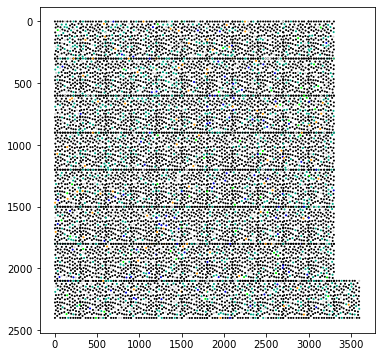

In [27]:
plt.clf()
fig, ax2 = plt.subplots(1,1,figsize=(6,6))
plt.scatter(np.array(point_list)[:,0], np.array(point_list)[:,1], c=colors, s=1)
#plt.hlines(y_bounds,min(x_bounds), max(x_bounds))
#plt.vlines(x_bounds,min(y_bounds), max(y_bounds))
#ax2.set(xlim=(0 - 0.01*ab[0], ab[0] + 0.01 * ab[0]), ylim=(7100, 0 - 0.01*ab[1]/2))
#plt.savefig('../fig/full_osmfish_brain_400px_300tiles_28cells.png', dpi=400)
plt.gca().invert_yaxis()
plt.show()

In [28]:
np.sum(B_composite, axis = 0)/B_composite.shape[0]

array([0.8220305 , 0.01113563, 0.10483547, 0.00652087, 0.01033307,
       0.04514446])

In [29]:
v, c = np.unique(df['cell_type_id'], return_counts = True)
c/np.sum(c)

array([0.83259019, 0.0131739 , 0.10944467, 0.00841103, 0.01337657,
       0.02300365])